In [5]:
import pandas as pd
import json
import os

path_labels_lifecycle = 'labels_lifecycle.json'
folder = os.path.join("..", "0_dataset")
log_files = [['label_syslog_disk_wipe.csv', 1],
               ['label_syslog_end_point_dos.csv', 4],
               ['label_syslog_mirai.csv', 0],
               ['label_syslog_ransomware.csv', 2],
               ['label_syslog_resource_hijacking.csv', 3]]
merged_list = ['results_T.csv', 'results_A.csv', 'results_L.csv', 'results_A+L.csv', 'results_A+T.csv', 'results_L+T.csv', 'results_A+L+T.csv']
# merged_list = ['results_A+L+T.csv']
folder_lifecycle = 'lifecycle'

Get start and end time for each scenario

In [63]:
time_list = []
for file, label in log_files:
    df_tmp = pd.read_csv(os.path.join(folder, 'syslog', file))
    time_list.append([df_tmp['Timestamp'].iloc[0], df_tmp['Timestamp'].iloc[-1], label])
    
print(time_list)

[[1673433290.0, 1673434411.0, 1], [1673439558.0, 1673440994.0, 4], [1673430856.0, 1673432522.0, 0], [1673435423.0, 1673436706.0, 2], [1673437131.0, 1673438383.0, 3]]


Original Technique Sequences Collection

In [89]:
df_test = pd.DataFrame(columns=['lifecycle', 'Label'])
df_test['lifecycle'] = df_test['lifecycle'].astype('object')
df_train = df_test.copy()
df_pattern = df_test.copy()

# get label
with open(path_labels_lifecycle, "r") as f:
    data = json.load(f)
    for label, name in data[1:]:
        isfind = False
        for start, end, label_time in time_list:
            if int(label) == label_time:
                t_start = start
                t_end = end
                isfind = True
                print(f'\nlabel:{label} t_start:{t_start}, t_end:{t_end}')
                break
        
        if isfind == False:
            continue
        
        # get merged sequences
        def preprocess_seq(df_tmp, label, target_col):
            seq = df_tmp.loc[((df_tmp['TIMESTAMP'] >= t_start) & (df_tmp['TIMESTAMP'] <= t_end)), target_col].tolist()
            while seq and seq[0] == 0:
                seq.pop(0)
            while seq and seq[-1] == 0:
                seq.pop()
            return pd.Series([seq, label], index=['lifecycle', 'Label'])
        
        for merged_res in merged_list:
            df_tmp = pd.read_csv(os.path.join(folder, folder_lifecycle, merged_res))
            # df_test.loc[len(df_test)] = preprocess_seq(df_tmp, label, 'pred')
            # df_train.loc[len(df_train)] = preprocess_seq(df_tmp, label, 'label')
            df_train.loc[len(df_train)] = preprocess_seq(df_tmp, label, 'pred')
            
            df_show = df_tmp.loc[((df_tmp['TIMESTAMP'] >= t_start) & (df_tmp['TIMESTAMP'] <= t_end)), 'pred']
            print(f'{merged_res}: start:{t_start} end:{t_end} len:{len(df_show)}')
            
            if 'A+L+T' in merged_res:
                # df_pattern.loc[len(df_pattern)] = preprocess_seq(df_tmp, label, 'label')
                df_pattern.loc[len(df_pattern)] = preprocess_seq(df_tmp, label, 'pred')

# print(df_test.info)
print(df_train.info)
print(df_pattern.info)
# df_test.to_csv(os.path.join(folder, folder_lifecycle, 'lifecycle_test_original.csv'), encoding='utf-8', index=False)
df_train.to_csv(os.path.join(folder, folder_lifecycle, 'lifecycle_train_original.csv'), encoding='utf-8', index=False)
df_pattern.to_csv(os.path.join(folder, folder_lifecycle, 'lifecycle_pattern.csv'), encoding='utf-8', index=False)


label:0 t_start:1673430856.0, t_end:1673432522.0
results_T.csv: start:1673430856.0 end:1673432522.0 len:1656
results_A.csv: start:1673430856.0 end:1673432522.0 len:1667
results_L.csv: start:1673430856.0 end:1673432522.0 len:1667
results_A+L.csv: start:1673430856.0 end:1673432522.0 len:1667
results_A+T.csv: start:1673430856.0 end:1673432522.0 len:1667
results_L+T.csv: start:1673430856.0 end:1673432522.0 len:1667
results_A+L+T.csv: start:1673430856.0 end:1673432522.0 len:1667

label:1 t_start:1673433290.0, t_end:1673434411.0
results_T.csv: start:1673433290.0 end:1673434411.0 len:945
results_A.csv: start:1673433290.0 end:1673434411.0 len:1122
results_L.csv: start:1673433290.0 end:1673434411.0 len:1122
results_A+L.csv: start:1673433290.0 end:1673434411.0 len:1122
results_A+T.csv: start:1673433290.0 end:1673434411.0 len:1122
results_L+T.csv: start:1673433290.0 end:1673434411.0 len:1122
results_A+L+T.csv: start:1673433290.0 end:1673434411.0 len:1122

label:2 t_start:1673435423.0, t_end:1673

Technique Sequence Dataset Generation

In [90]:
import ast
import random

data_type = 'train'
# data_type = 'test'
df = pd.read_csv(os.path.join(folder, folder_lifecycle, 'lifecycle_'+data_type+'_original.csv'))

times_generating = 200 # train: 200, test: 40
len_rand = 5


df_new = pd.DataFrame(columns=['lifecycle', 'Label'])
max_len = 0
for i in range(times_generating):
    for j, item in enumerate(df['lifecycle']):
        list_new = []
        lifecycle = ast.literal_eval(item)
        index = 0
        while index < len(lifecycle):
            if lifecycle[index] != 0:
                list_new.append(lifecycle[index])
                index += 1
            else:
                index_new = index
                while index_new < len(lifecycle) and lifecycle[index_new] == 0:
                    index_new += 1
                len_0 = index_new - index
                num_rand = random.randint(max(0, len_0 - len_rand), len_0 + len_rand)
                list_new.extend([0] * num_rand)
                index = index_new

        max_len = max(max_len, len(list_new))
        # print(len(lifecycle))
        # print(len(list_new))
        # print('----')
        df_new.loc[len(df_new)] = pd.Series([list_new, df['Label'][j]], index=['lifecycle', 'Label'])

df = pd.concat([df, df_new], ignore_index=True)
df.to_csv(os.path.join(folder, folder_lifecycle, 'lifecycle_dataset_'+data_type+'.csv'), encoding='utf-8', index=False)

print(f'max sequence length: {max_len}')
for label in sorted(df['Label'].unique()):
    len_label = len(df[df['Label'] == label])
    print(f'label {label} total data: {len_label}')
print(df)

max sequence length: 1961
label 0 total data: 1407
label 1 total data: 1407
label 2 total data: 1407
label 3 total data: 1407
label 4 total data: 1407
                                              lifecycle Label
0     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, ...     0
1     [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     0
2     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...     0
3     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...     0
4     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, ...     0
...                                                 ...   ...
7030  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...     4
7031  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     4
7032  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, ...     4
7033  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...     4
7034  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...     4

[7035 rows x 2 columns]


Common Techniques (LCS DP)

In [59]:
# import ast
# from itertools import groupby

# df = pd.read_csv(os.path.join(folder, folder_lifecycle, 'lifecycle_dataset_patterns.csv'))
# labels = [0, 1, 2, 3, 4]
# # target_label = 0
# # target = df[df['Label'] == target_label].values[0][0]
# # df_remain = df[df['Label'] != target_label]
# # res = {}

# def preprocess(df, index):
#     '''
#     seq: str type, but content is list
#     '''
#     seq = df[df['Label'] == index].values[0][0]
#     seq = ast.literal_eval(seq)
#     seq = [value for value in seq if value != 0]
#     seq = [key for key, _group in groupby(seq)]
    
#     return seq

# def lcs(X, Y):
#     '''
#     X, Y: both are list
#     '''
#     m = len(X)
#     n = len(Y)
#     L = [[0] * (n + 1) for i in range(m + 1)]
    
#     for i in range(1, m + 1):
#         for j in range(1, n + 1):
#             if X[i - 1] == Y[j - 1]:
#                 L[i][j] = L[i - 1][j - 1] + 1
#             else:
#                 L[i][j] = max(L[i - 1][j], L[i][j - 1])
    
#     index = L[m][n]
#     common_seq = [None] * index
#     i = m
#     j = n
#     while i > 0 and j > 0:
#         if X[i - 1] == Y[j - 1]:
#             common_seq[index - 1] = X[i - 1]
#             i -= 1
#             j -= 1
#             index -= 1
#         elif L[i - 1][j] > L[i][j - 1]:
#             i -= 1
#         else:
#             j -= 1
    
#     return common_seq


# for i in range(len(labels)-1):
#     for j in range(i+1, len(labels)):
#         seq1 = preprocess(df, labels[i])
#         seq2 = preprocess(df, labels[j])
#         common_seq = lcs(seq1, seq2)
        
#         print(f'lifecycle {i} and lifecycle {j}:')
#         print(f'lifecycle {i}:\n{seq1}')
#         print(f'lifecycle {j}:\n{seq2}')
#         print(f'common techs:\n{common_seq}\n')

lifecycle 0 and lifecycle 1:
lifecycle 0:
[1, 14, 1, 4, 1, 2, 14, 1, 13, 15, 13]
lifecycle 1:
[1, 14, 1, 14, 1, 14, 1, 14, 1, 14, 4, 2, 4, 1, 2, 1, 2, 1, 4, 1, 2, 4, 1, 4, 1, 4, 2, 1, 14, 1, 14]
common techs:
[1, 14, 1, 4, 1, 2, 14, 1]

lifecycle 0 and lifecycle 2:
lifecycle 0:
[1, 14, 1, 4, 1, 2, 14, 1, 13, 15, 13]
lifecycle 2:
[1, 14, 1, 2, 4, 13, 2, 1, 13, 1, 13, 8, 13, 1, 14, 13, 1, 13, 1, 13, 1, 13, 1, 13, 15, 13]
common techs:
[1, 14, 1, 4, 2, 14, 1, 13, 15, 13]

lifecycle 0 and lifecycle 3:
lifecycle 0:
[1, 14, 1, 4, 1, 2, 14, 1, 13, 15, 13]
lifecycle 3:
[1, 14, 1, 2, 1, 4, 2, 1, 4, 1, 4, 1, 4, 1, 14, 1, 2, 1, 14, 1]
common techs:
[1, 14, 1, 4, 1, 2, 14, 1]

lifecycle 0 and lifecycle 4:
lifecycle 0:
[1, 14, 1, 4, 1, 2, 14, 1, 13, 15, 13]
lifecycle 4:
[1, 8, 14, 2, 4, 2, 4, 2, 4, 2, 4, 14, 15, 17, 13, 1, 13, 1, 13]
common techs:
[1, 14, 4, 2, 14, 1, 13, 13]

lifecycle 1 and lifecycle 2:
lifecycle 1:
[1, 14, 1, 14, 1, 14, 1, 14, 1, 14, 4, 2, 4, 1, 2, 1, 2, 1, 4, 1, 2, 4, 1, 4, 1, 

Sequence Matching

In [170]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split 
import ast
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_similarity(A, B):
    '''
    use levenshtein distance to compute the similarity
    '''
    m = len(A)
    n = len(B)
    D = [[0] * (n + 1) for i in range(m + 1)]

    for i in range(m + 1):
        D[i][0] = i
    for j in range(n + 1):
        D[0][j] = j

    for j in range(1, n + 1):
        for i in range(1, m + 1):
            if A[i - 1] == B[j - 1]:
                D[i][j] = D[i - 1][j - 1]
            else:
                D[i][j] = min(D[i - 1][j] + 1, D[i][j - 1] + 1, D[i - 1][j - 1] + 1)

    similarity = 1.0 - (float(D[m][n]) / float(max(len(A), len(B))))

    return similarity

def text_to_list(data):
    res = []
    for s in data:
        l = ast.literal_eval(s)
        l = [int(x) for x in l if int(x) != 0]
        tmp = []
        for i in range(1, len(l)):
            if l[i] != l[i-1]:
                tmp.append(l[i])
        res.append(tmp)
        # print(tmp)
        
    return res

def text_to_list_dict(d):
    for key, value in d.items():
        tmp = text_to_list([value])
        d[key] = tmp[0]
    
    return d


df = pd.read_csv(os.path.join(folder, folder_lifecycle, 'lifecycle_dataset_train.csv'))
# df = pd.read_csv(os.path.join(folder, folder_lifecycle, 'lifecycle_train_original.csv'))
df_pattern = pd.read_csv(os.path.join(folder, folder_lifecycle, 'lifecycle_pattern.csv'))
pattern_dict = df_pattern.set_index('Label')['lifecycle'].to_dict()
pattern_dict = text_to_list_dict(pattern_dict)

X = df['lifecycle'].values
X = text_to_list(X)
# X = np.array(X)
y = df['Label']
y = y.to_numpy()
y = y.reshape(-1)

random_seed = 42

X_test = X
y_test = y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# unique_sublists = []
# for sublst in X_test:
#     if sublst not in unique_sublists:
#         unique_sublists.append(sublst)
# print(len(unique_sublists))

# get all similarity for each testing data
preds = []
print(f'size: {len(X_test)}')
for i in range(len(X_test)):
    # get similarity for each class
    similarity_dict = {}
    for k, value in pattern_dict.items():
        similarity_dict[k] = get_similarity(X_test[i], value)
    # print(i, similarity_dict, y_test[i]) 
    preds.append(max(similarity_dict.items(), key=lambda x: x[1])[0])
    
print(accuracy_score(y_test, preds,))
print(precision_score(y_test, preds, average='weighted',zero_division=0))
print(recall_score(y_test, preds, average='weighted', zero_division=0))
print(f1_score(y_test, preds, average='weighted', zero_division=0))

size: 1785
0.3142857142857143
0.1409090909090909
0.3142857142857143
0.18853046594982079


confusion matrix - SM

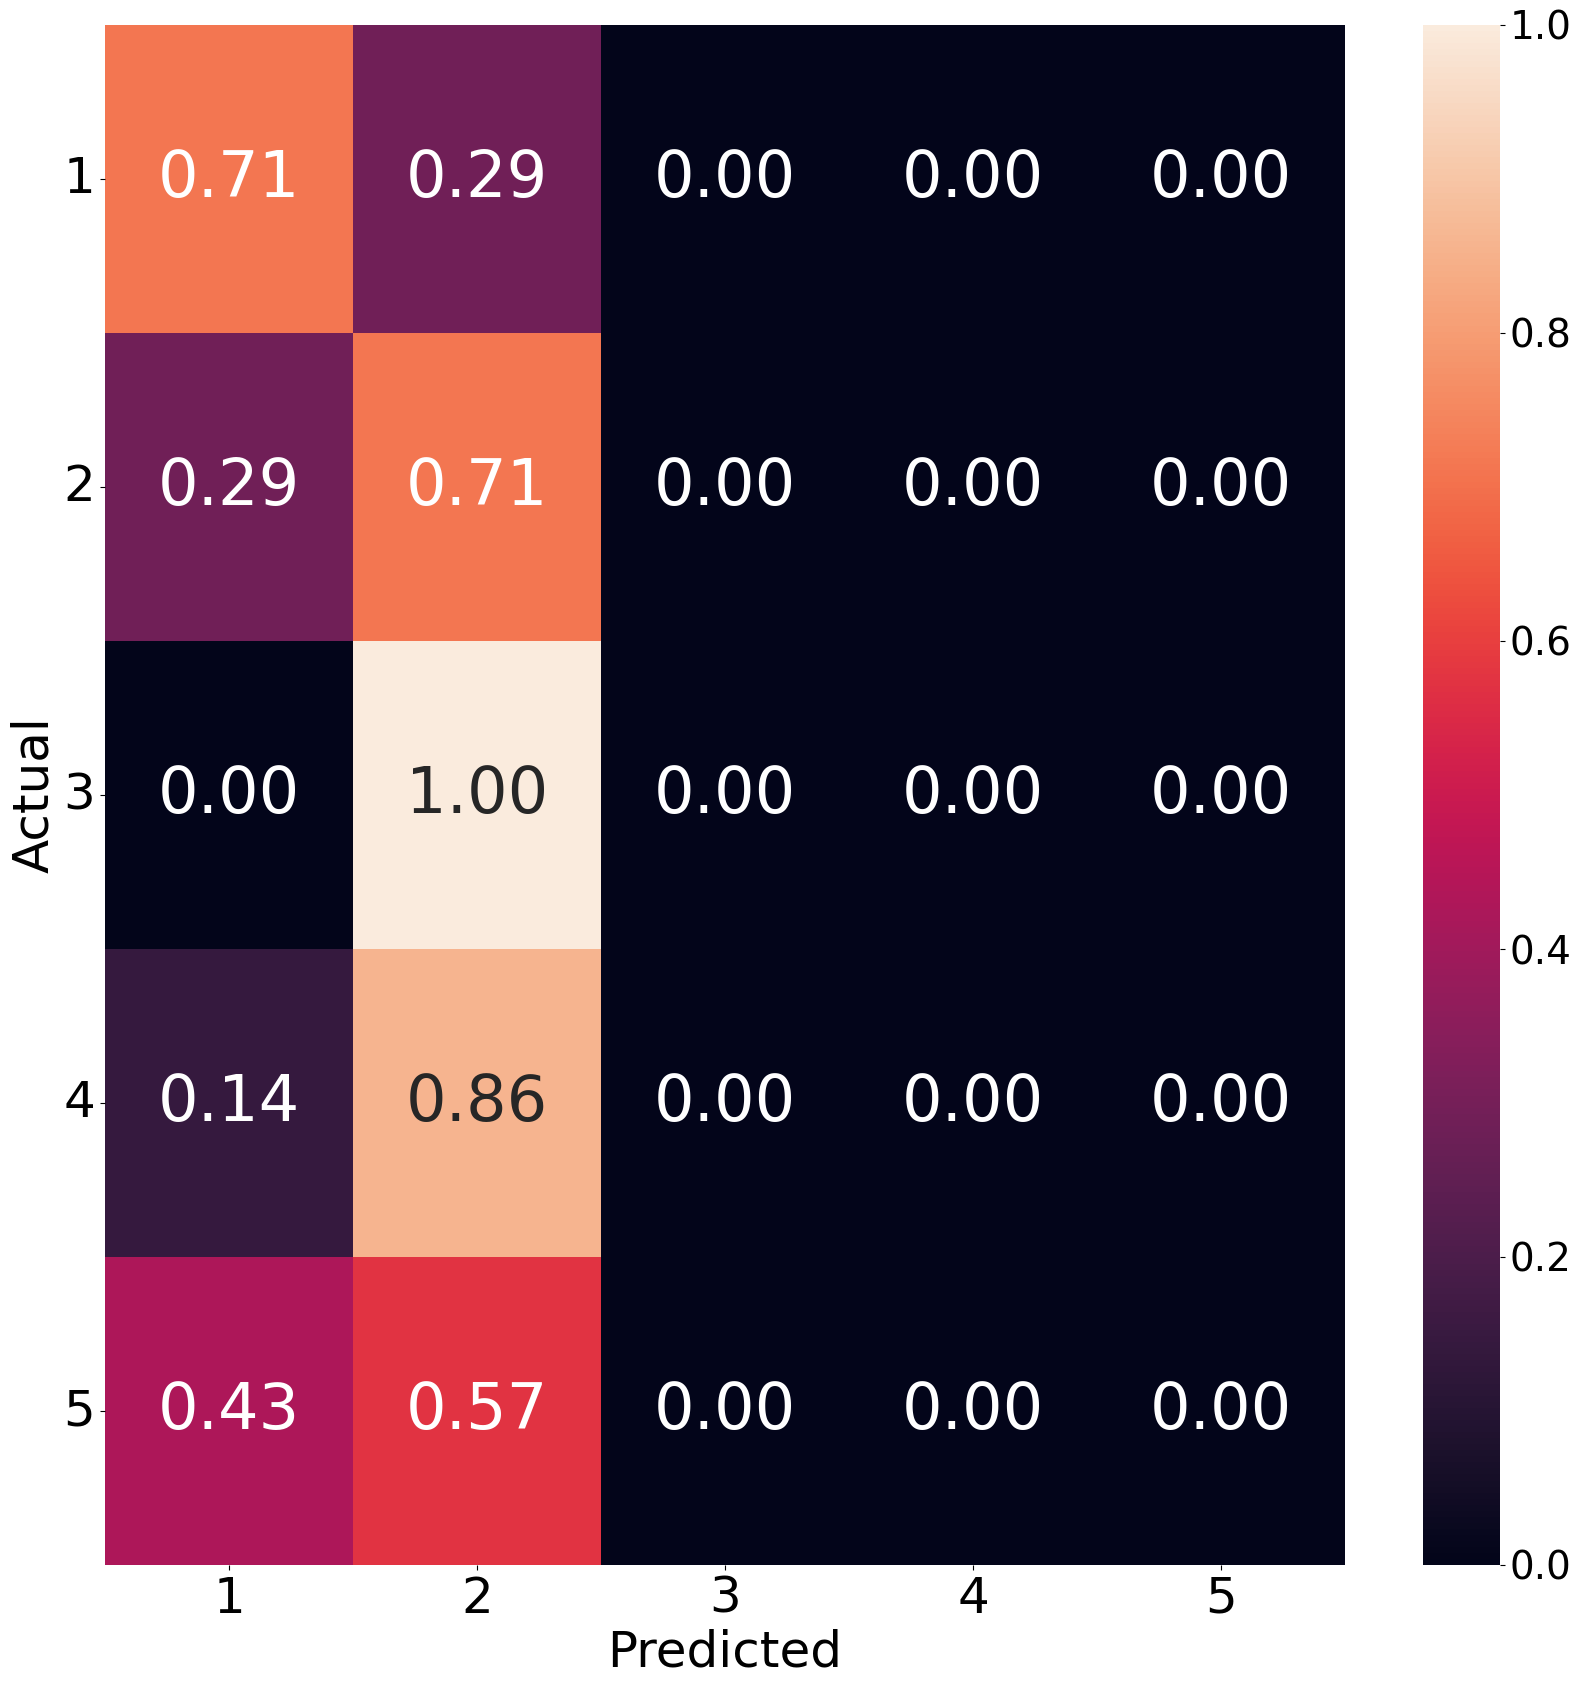

In [219]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

target_names = sorted(i for i in range(1, 6))

# label replacement 1->3, 2->1, 3->2
y_test_tmp = y_test
preds_tmp = preds

y_test_tmp = np.where(y_test_tmp == 1, -1, y_test_tmp)
y_test_tmp = np.where(y_test_tmp == 2, 1, y_test_tmp)
y_test_tmp = np.where(y_test_tmp == 3, 2, y_test_tmp)
y_test_tmp = np.where(y_test_tmp == -1, 3, y_test_tmp)

preds_tmp = np.where(preds_tmp == 1, -1, preds_tmp)
preds_tmp = np.where(preds_tmp == 2, 1, preds_tmp)
preds_tmp = np.where(preds_tmp == 3, 2, preds_tmp)
preds_tmp = np.where(preds_tmp == -1, 3, preds_tmp)


cm = confusion_matrix(y_test_tmp, preds_tmp)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, annot_kws={"size": 46})
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=28)
# plt.title('Confusion Matrix', fontsize=30)
plt.ylabel('Actual', fontsize=36)
plt.xlabel('Predicted', fontsize=36)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
plt.show(block=False)

In [134]:
# def get_similarity(A, B):
#     '''
#     use levenshtein distance to compute the similarity
#     '''
#     m = len(A)
#     n = len(B)
#     D = [[0] * (n + 1) for i in range(m + 1)]

#     for i in range(m + 1):
#         D[i][0] = i
#     for j in range(n + 1):
#         D[0][j] = j

#     for j in range(1, n + 1):
#         for i in range(1, m + 1):
#             if A[i - 1] == B[j - 1]:
#                 D[i][j] = D[i - 1][j - 1]
#             else:
#                 D[i][j] = min(D[i - 1][j] + 1, D[i][j - 1] + 1, D[i - 1][j - 1] + 1)

#     # print(D[m][n], len(A), len(B))
#     similarity = 1.0 - (float(D[m][n]) / float(max(len(A), len(B))))

#     return similarity

# C = [1,1,0,3,0,0,3,0,5,5]
# A = [1,0,0,1,0,3,3,0,0,5,0,5]
# B = [1,1,0,2,0,0,2,0,4,5]

# print(get_similarity(A,C))
# print(get_similarity(B,C))

0.5833333333333333
0.7


3 approaches comparison

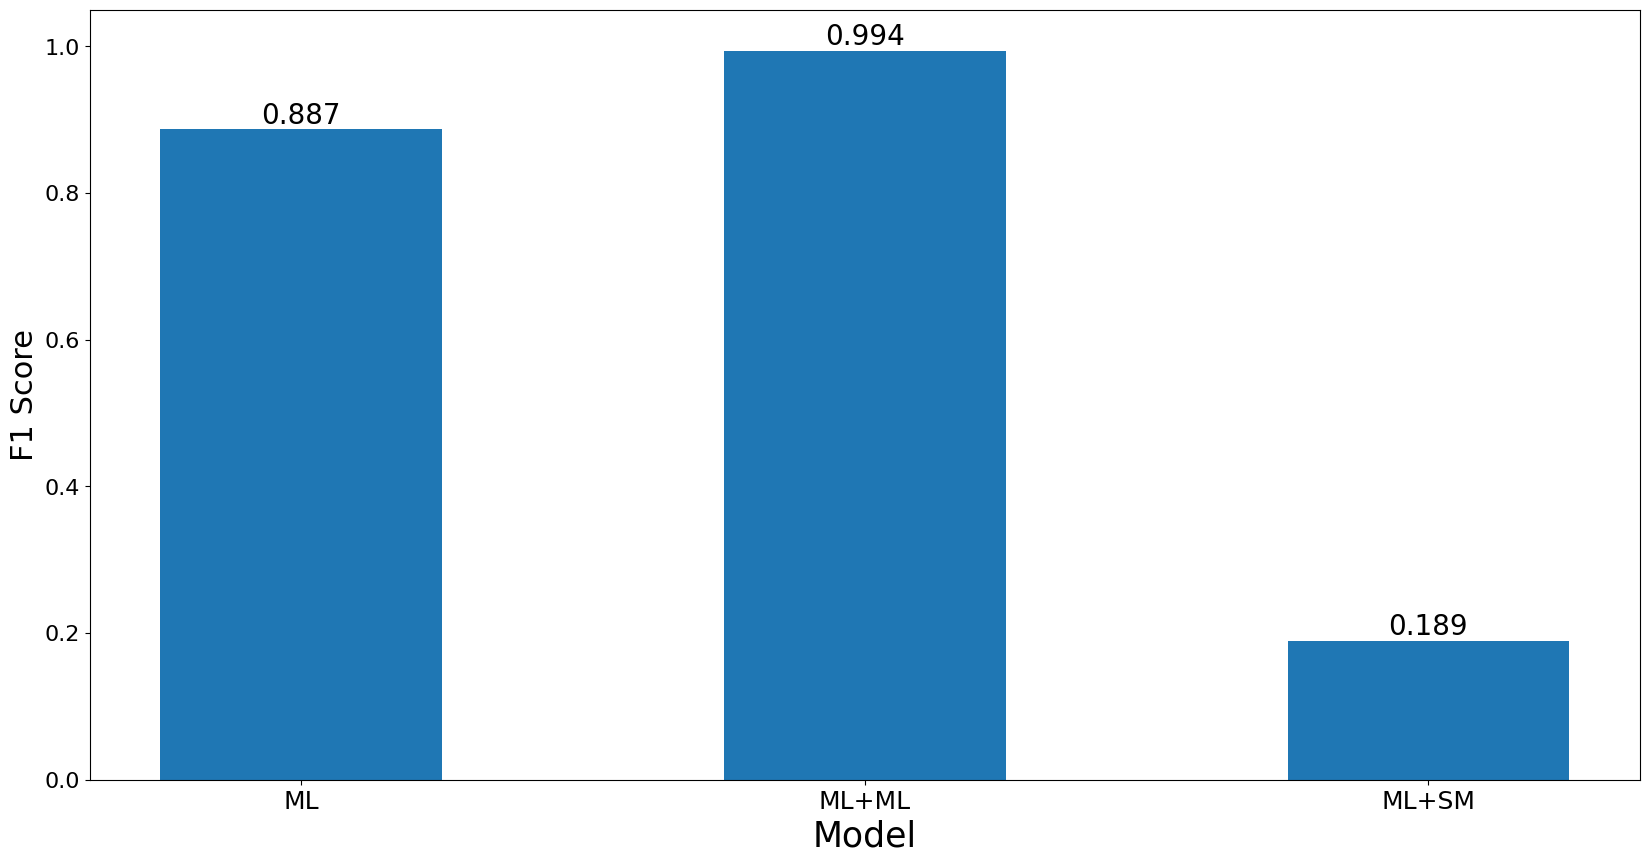

In [165]:
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math

methods = ['ML', 'ML+ML', 'ML+SM']

evaluation = {}
for name in methods:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
evaluation['ML']['accuracy'].append(0.879)
evaluation['ML']['precision'].append(0.907)
evaluation['ML']['recall'].append(0.879)
evaluation['ML']['f1_score'].append(0.887)

evaluation['ML+ML']['accuracy'].append(0.994)
evaluation['ML+ML']['precision'].append(0.994)
evaluation['ML+ML']['recall'].append(0.994)
evaluation['ML+ML']['f1_score'].append(0.994)

# # dataset with 5 lifecycles
# evaluation['ML+SM']['accuracy'].append(0.871)
# evaluation['ML+SM']['precision'].append(0.92)
# evaluation['ML+SM']['recall'].append(0.871)
# evaluation['ML+SM']['f1_score'].append(0.826)

# # dataset with 35 lifecycles
# evaluation['ML+SM']['accuracy'].append(0.56)
# evaluation['ML+SM']['precision'].append(0.632)
# evaluation['ML+SM']['recall'].append(0.56)
# evaluation['ML+SM']['f1_score'].append(0.57)

# # original 35
# evaluation['ML+SM']['accuracy'].append(0.543)
# evaluation['ML+SM']['precision'].append(0.63)
# evaluation['ML+SM']['recall'].append(0.543)
# evaluation['ML+SM']['f1_score'].append(0.552)

# original 35 with original sequence
evaluation['ML+SM']['accuracy'].append(0.314)
evaluation['ML+SM']['precision'].append(0.141)
evaluation['ML+SM']['recall'].append(0.314)
evaluation['ML+SM']['f1_score'].append(0.189)


def round_off(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(round_off(mean(value), 3))
        
        if name == 'Bi-GRU':
            print(f'metric {key}: {round_off(mean(value), 3)}')

width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
# plt.bar(x, result['accuracy'], width, label='accuracy')
# plt.bar(x+width, result['precision'], width, label='precision')
# plt.bar(x+2*width, result['recall'], width, label='recall')
# bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
bar = plt.bar(x, result['f1_score'], 0.5, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=20)
# plt.title('3 Approaches Comparison', fontsize=30)
# plt.xticks(x+1.5*width, models)
plt.xticks(x, models)
plt.xlabel('Model', fontsize=25)
plt.ylabel('F1 Score', fontsize=22)
plt.rcParams.update({
    'xtick.labelsize': 18,
    'ytick.labelsize': 16,
})
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=4, fontsize=20)
plt.ylim(0, 1.05)
plt.show()

confusion matrix - all

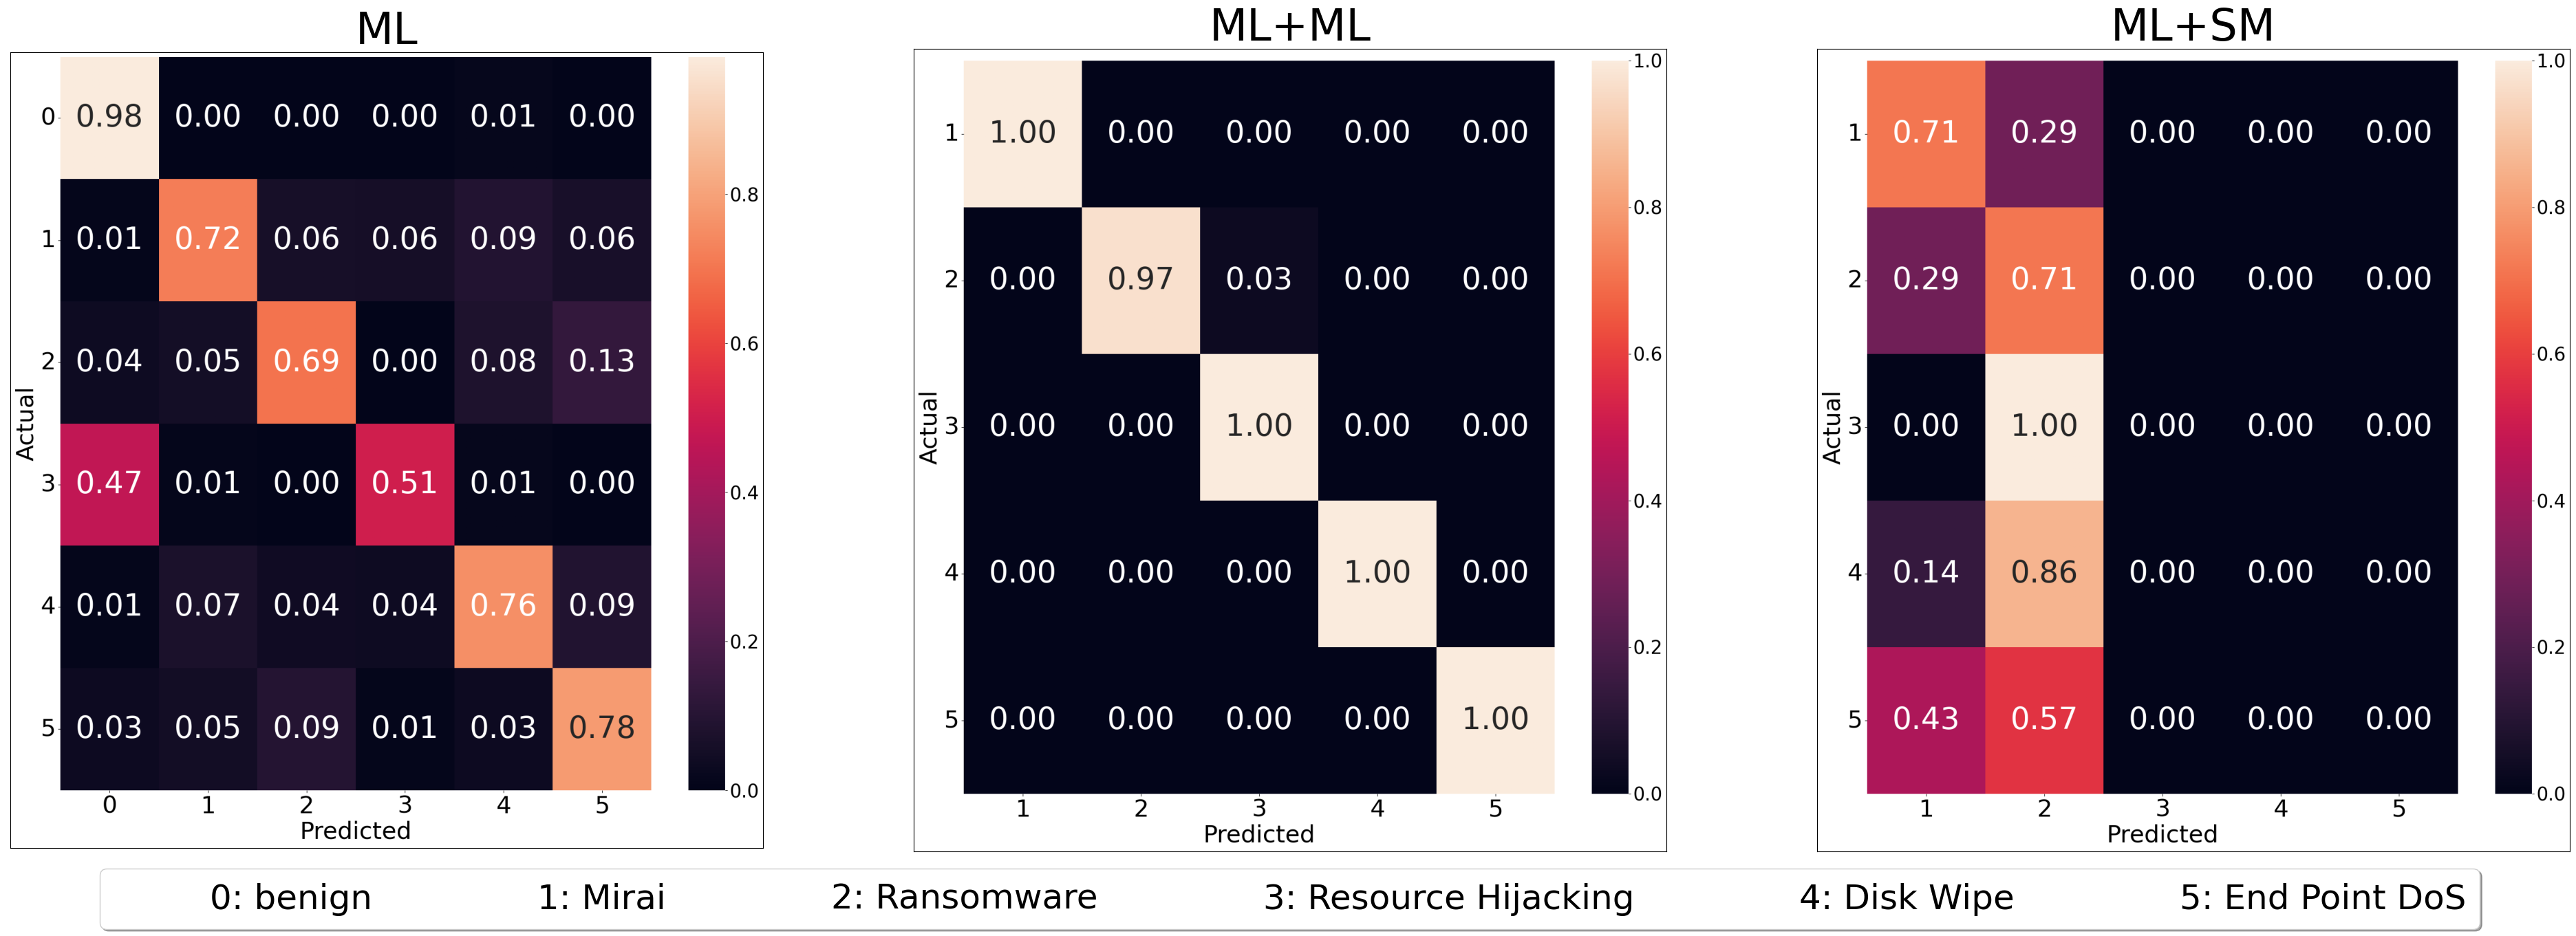

<Figure size 6400x4800 with 0 Axes>

In [223]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.patches as mpatches

image_a = imread('ML_conf.png')
image_b = imread('ML+ML_conf.png')
image_c = imread('ML+SM_conf.png')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(48, 48))


ax1.imshow(image_a)
ax2.imshow(image_b)
ax3.imshow(image_c)

ax1.set_title('ML', fontsize=46)
ax2.set_title('ML+ML', fontsize=46)
ax3.set_title('ML+SM', fontsize=46)

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])


fig.suptitle('Comparison of Confusion Matrices', fontsize=24)

handles = []
handles.append(mpatches.Patch(color='white', label='0: benign'))
handles.append(mpatches.Patch(color='white', label='1: Mirai'))
handles.append(mpatches.Patch(color='white', label='2: Ransomware'))
handles.append(mpatches.Patch(color='white', label='3: Resource Hijacking'))
handles.append(mpatches.Patch(color='white', label='4: Disk Wipe'))
handles.append(mpatches.Patch(color='white', label='5: End Point DoS'))
# plt.legend(bbox_to_anchor=(1.55, 1), handles=handles, loc='upper right', fontsize=10)
# plt.legend(loc='upper center', handles=handles, bbox_to_anchor=(0.5, 0), shadow=True, ncol=3, fontsize=36)
plt.legend(loc='upper center', handles=handles, bbox_to_anchor=(-0.7, 0), shadow=True, ncol=6, fontsize=36)

# plt.tight_layout()

plt.figure(dpi=1000)
plt.show()